# FGSM MNIST
Please see the file fgsm.ipynb for an introduction in the FGSM related methods. Here follows an evaluation of adverserial training using FGSM related methods.

In [67]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

import json
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.autograd import Variable
import torch.nn.functional as F

In [68]:

# Define the MNIST model
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout(0.25)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = torch.nn.functional.softmax(x, dim=1)
        return output

In [3]:
# Read the example image
image = Image.open("../../data/pictures/4.png")

mean = (0.1307,)
std = (0.3081,)

# Resize to 224, convert to PyTorch Tensor and perform normalization
preprocess = transforms.Compose([
   transforms.Resize(28),
   transforms.ToTensor(),
   transforms.Normalize(std, mean)
])

# Add batch dimension
image_tensor = preprocess(image).unsqueeze(0)

image_variable = Variable(image_tensor, requires_grad=True)

In [4]:
def show_image(image_variable, pred_label, prob):
    # remove batch dimension
    img = image_variable.squeeze(0)
    
    # Undo normalizations
    img = img.mul(torch.FloatTensor(std).view(1,1,1)).add(torch.FloatTensor(mean).view(1,1,1)).detach().numpy()

    # Convert C X H X W -->  H X W X C
    img = np.transpose(img, (1,2,0))   
    img = np.clip(img, 0, 1)
    
    figure, ax = plt.subplots(1,1, figsize=(4,4))
    
    #ax.imshow(img)
    
    ax.imshow(img, cmap = "gray")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])

    
    ax.text(0.5, -0.2,
            'Prediction: {}\n Probability: {:.4f}'.format(pred_label, prob),
            size=12, ha="center", transform=ax.transAxes)
    
    plt.show()
    

In [5]:

# Initialize the pre-trained model
model = Net()
model.load_state_dict(torch.load('../../data/models/mnist_cnn.pt', map_location=torch.device('cpu')))
model.eval();


# Original model performance

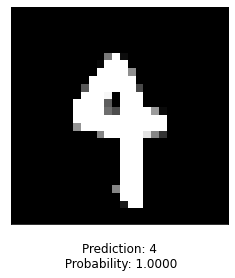

In [6]:
pred = model(image_variable)

label = pred.argmax().item()
prob = pred.max().item()

# plot image
show_image(image_variable, label, prob)


# Fast Gradient Sign Method


In [7]:
def fgsm(model, X, y, epsilon=0.1):
    
    delta = torch.zeros_like(X, requires_grad=True)
    
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    
    loss.backward()
    
    return epsilon * delta.grad.detach().sign()

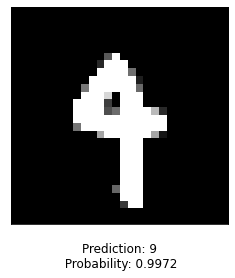

In [8]:
delta = fgsm(model, image_variable, torch.tensor([4]), 0.4)
pred_fgsm = model(image_variable + delta)
label = pred_fgsm.argmax().item()
prob = pred_fgsm.max().item()


# plot image
show_image(image_variable + delta, label, prob)

# One step least-likely class

In [57]:
def onestepllclass(model, X, y_target, epsilon=0.1):
    
    delta = torch.zeros_like(X, requires_grad=True)
    
    loss = nn.CrossEntropyLoss()(model(X + delta), y_target)
    
    loss.backward()
    
    return - epsilon * delta.grad.detach().sign()


In [58]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(y_target))

least likely class: 0


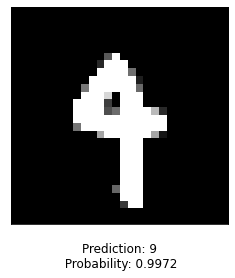

In [59]:
delta = onestepllclass(model, image_variable, torch.tensor([y_target]), 0.4)
pred_fgsm = model(image_variable + delta)
label = pred_fgsm.argmax().item()
prob = pred_fgsm.max().item()


# plot image
show_image(image_variable + delta, label, prob)

# Basic iterative method attack


In [51]:

def bim(model, X, y, epsilon=0.1, alpha=1, num_steps=10):

    delta = torch.zeros_like(X, requires_grad=True)
        
    for i in range(num_steps):
        
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        
        loss.backward()
        
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        
        delta.grad.zero_()
        
    return delta.detach()


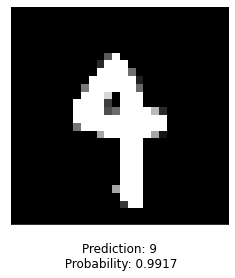

In [52]:
delta = bim(model, image_variable, torch.tensor([4]), 0.4, 1, 10)
pred_fgsm = model(image_variable + delta)
label = pred_fgsm.argmax().item()
prob = pred_fgsm.max().item()


# plot image
show_image(image_variable + delta, label, prob)

# Iterative leasy-likely class method

In [64]:
def iterativellclass(model, X, y_target, epsilon=0.1, alpha=1, num_steps=10):

    delta = torch.zeros_like(X, requires_grad=True)
        
    for i in range(num_steps):
        
        loss = nn.CrossEntropyLoss()(model(X - delta), y_target)
        
        loss.backward()
        
        delta.data = (delta - alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        
        delta.grad.zero_()
        
    return delta.detach()

In [65]:
# find least likely class
pred = model(image_variable)
y_target = torch.argmin(pred).item()
print('least likely class: {}'.format(y_target))

least likely class: 0


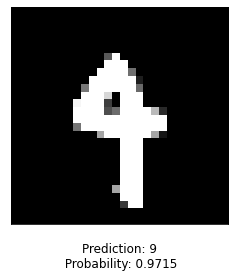

In [66]:
delta = iterativellclass(model, image_variable, torch.tensor([y_target]), 0.4, 1, 10)
pred_fgsm = model(image_variable + delta)
label = pred_fgsm.argmax().item()
prob = pred_fgsm.max().item()


# plot image
show_image(image_variable + delta, label, prob)

# Performance on adverserial trained model

Here we show the effects of adverserial training. Adverserial training works a follows: instead of only training on regular examples from the dataset, we also use adverserial examples at every step of the training.


#TODO choose epsilon randomly

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

opt = optim.SGD(model.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch(train_loader, model, opt)
    test_err, test_loss = epoch(test_loader, model)
    adv_err, adv_loss = epoch_adversarial(test_loader, model, fgsm)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model.pt")


KeyboardInterrupt: 

In [ ]:
import copy
model_robust = copy.deepcopy(model)
opt = optim.SGD(model_robust.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(train_loader, model_robust, fgsm, opt)
    test_err, test_loss = epoch(test_loader, model_robust)
    adv_err, adv_loss = epoch_adversarial(test_loader, model_robust, fgsm)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model_robust.state_dict(), "model_robust.pt")


# References

Goodfellow, I. J., Shlens, J., & Szegedy, C. (2015). Explaining and Harnessing Adversarial Examples. ArXiv:1412.6572 [Cs, Stat]. http://arxiv.org/abs/1412.6572

Kurakin, A., Goodfellow, I., & Bengio, S. (2017). Adversarial Machine Learning at Scale. ArXiv:1611.01236 [Cs, Stat]. http://arxiv.org/abs/1611.01236

Madry, Z. K. and A. (n.d.). Adversarial Robustness—Theory and Practice. Retrieved November 8, 2021, from http://adversarial-ml-tutorial.org/
